# STA 220 Final Project

Hongyi Deng, Chengkai Shi

In [95]:
import numpy as np
import pandas as pd
import requests
import lxml.html as lx
import re
import time
import json
import nltk
from nltk.corpus import names
from re import findall

from sklearn.feature_extraction.text import CountVectorizer
from nltk.classify import NaiveBayesClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from nltk.classify.util import accuracy
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import warnings


In [6]:
# use API to retrieve the urls (already convered in the interactive map)

# api_key='j8Q2sqYK3mLSJxATCqSUyvMUxfRHURDoIMdRJ6V-G8WohBcs9hEsXa1kHeLbOyZCwvFRGvOVlSUdQLHQVUu1OMKKFTAS6sRTQh6syLSP0UHSwxj4yNrduxWkOFPuZXYx'
# headers={'Authorization': f'Bearer {api_key}',}
# url='https://api.yelp.com/v3/businesses/search'
# params={'term': 'Chinese',
#         'location': 'Sacramento',
#         'limit':15}

# response=requests.get(url, headers=headers, params=params)
# result=response.json()
# urls=[]
# for b in result['businesses']:
#     urls.append(b['url'])
# print(urls)

### Scrap the reviews and ratings

In [8]:
def ratings_reviews_onepage(url):
    response=requests.get(url).text
    html=lx.fromstring(response)
    ratings_all=re.findall(r'aria-label="(\d+(?:\.\d+)?) star rating"',response)  
    reviews_all=re.findall(r'(?<=en">)(.*?)(?=</span>)', response)             
    reviews=[re.sub('<br>','', r) for r in reviews_all]
    if 'You Might Also Consider' in response:                                              
        ratings=ratings_all[4:4+len(reviews)]
    else:
        ratings=ratings_all[2:2+len(reviews)]
    return (ratings, reviews)        

In [9]:
def ratings_reviews_all(url):
    i=2; 
    ratings, reviews=ratings_reviews_onepage(url)
    while i<=9:   
        time.sleep(2.5)  
        page_num=(i-1)*10
        url_new=url+'&start='+str(page_num)
        ra_i,re_i=ratings_reviews_onepage(url_new)
        for ra in ra_i:
            ratings.append(ra)    
        for re in re_i:
            reviews.append(re)
        i=i+1
    return (ratings, reviews)    

In [10]:
# Retrieve all reviews+ratings of restaurants
ratings_all=[]; reviews_all=[]
for url in urls[0:5]:
    time.sleep(1)
    ratings, reviews=ratings_reviews_all(url)
    ratings_all.append(ratings)
    reviews_all.append(reviews)

In [21]:
ratings_all2=[i for sublist in ratings_all for i in sublist]
reviews_all2=[i for sublist in reviews_all for i in sublist]  
print(reviews_all2[0])
print(ratings_all2)
len(reviews_all2)

In Sac on business, wanted Chinese & SO SO happy we found this little gem!!Order & go, no inside seating but we didn't let that stop us!Staff super friendly and extremely fast with our order!  Food was steaming HOT & delicious  We will be back!!!
['5', '3', '4', '5', '4', '5', '5', '1', '4', '4', '5', '5', '4', '5', '4', '5', '5', '5', '5', '3', '5', '5', '4', '4', '5', '5', '2', '2', '4', '5', '4', '5', '5', '5', '5', '5', '4', '4', '5', '5', '5', '5', '4', '5', '5', '5', '3', '5', '5', '5', '5', '4', '3', '3', '4', '5', '1', '1', '4', '5', '3', '5', '4', '4', '1', '5', '5', '1', '5', '5', '5', '5', '5', '3', '4', '5', '4', '5', '5', '4', '5', '5', '4', '5', '5', '4', '5', '5', '5', '5', '5', '5', '5', '5', '4', '1', '4', '5', '1', '5', '5', '5', '5', '1', '5', '5', '4', '2', '5', '5', '2', '5', '5', '5', '5', '1', '5', '2', '5', '5', '5', '4', '5', '5', '5', '5', '5', '1', '5', '5', '5', '1', '5', '5', '5', '5', '5', '5', '4', '5', '5', '5', '5', '5', '5', '5', '4', '5', '5', '5', '3

472

### Organize the text we get

In [132]:
# Obtain the text+label
ratings_01=[int(i) for i in ratings_all2]
for i in range(len(ratings_01)):
    if ratings_01[i]>=3:
        ratings_01[i]='positive'
    else:
        ratings_01[i]='negtive'

re_ra=[(reviews_all2[i].lower(),ratings_01[i]) for i in range(len(reviews_all2))]
texts, labels = zip(*re_ra)

In [137]:
# remove the stop words
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))

def remove_stop_words(text):
    word_tokens=text.split()
    filtered_text=[word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

texts=[remove_stop_words(text) for text in texts]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Tokenizers

In [179]:
# Functions for 8 kinds of tokenizers
def bow(text):
    return text.split()

def bigram(text):
    words=text.split()
    return [' '.join(words[i:i+2]) for i in range(len(words)-1)]

def trigram(text):
    words=text.split()
    return [' '.join(words[i:i+3]) for i in range(len(words)-2)]

def fourgram(text):
    words=text.split()
    return [' '.join(words[i:i+4]) for i in range(len(words)-3)]

def fivegram(text):
    words=text.split()
    return [' '.join(words[i:i+5]) for i in range(len(words)-4)]

def sixgram(text):
    words=text.split()
    return [' '.join(words[i:i+6]) for i in range(len(words)-5)]

def sevengram(text):
    words=text.split()
    return [' '.join(words[i:i+7]) for i in range(len(words)-6)]

def eightgram(text):
    words=text.split()
    return [' '.join(words[i:i+8]) for i in range(len(words)-7)]

def ninegram(text):
    words=text.split()
    return [' '.join(words[i:i+9]) for i in range(len(words)-8)]

def fifteengram(text):
    words=text.split()
    return [' '.join(words[i:i+15]) for i in range(len(words)-14)]

def thirtygram(text):
    words=text.split()
    return [' '.join(words[i:i+30]) for i in range(len(words)-29)]

def sixtygram(text):
    words=text.split()
    return [' '.join(words[i:i+60]) for i in range(len(words)-59)]

def hundgram(text):
    words=text.split()
    return [' '.join(words[i:i+150]) for i in range(len(words)-149)]

def fhundgram(text):
    words=text.split()
    return [' '.join(words[i:i+400]) for i in range(len(words)-399)]

### Accuracy

In [180]:
# a function to train NaiveBayes classifier and calculate accuracy
def naive_bayes(tokenization_method, texts, labels):
    if tokenization_method=="bow":
        vectorizer = CountVectorizer()
    else:
        vectorizer = CountVectorizer(tokenizer=tokenization_method, analyzer='word')
   
    X=vectorizer.fit_transform(texts)
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42)
    
    # Train the NaiveBayes classifier
    modelNB=MultinomialNB()
    modelNB.fit(X_train, y_train)
    
    # Make predictions and compute accuracy
    y_pred=modelNB.predict(X_test)
    accuracy=accuracy_score(y_test, y_pred)
    return accuracy

Text(0, 0.5, 'Accuracy')

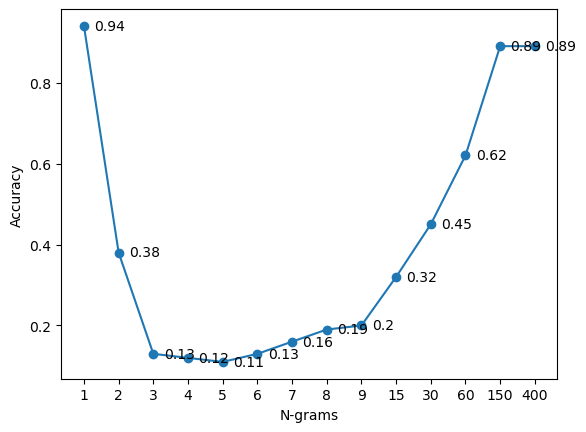

In [181]:
# Train and evaluate classifier for each tokenization method

a1=naive_bayes("bow", texts, labels); a2=naive_bayes(bigram,texts,labels); a3=naive_bayes(trigram,texts,labels); 
a4=naive_bayes(fourgram,texts,labels); a5=naive_bayes(fivegram,texts,labels); a6=naive_bayes(sixgram,texts,labels);
a7=naive_bayes(sevengram,texts,labels); a8=naive_bayes(eightgram,texts,labels); a9=naive_bayes(ninegram,texts,labels)
a15=naive_bayes(fifteengram,texts,labels); a30=naive_bayes(thirtygram,texts,labels); a60=naive_bayes(sixtygram,texts,labels)
a150=naive_bayes(hundgram,texts,labels); a400=naive_bayes(fhundgram,texts,labels)
a_vec=[a1,a2,a3,a4,a5,a6,a7,a8,a9,a15,a30,a60,a150,a400]
a_vec=[round(i,2) for i in a_vec]
warnings.filterwarnings('ignore')
x_axis=['1','2','3','4','5','6','7','8','9','15','30','60','150','400']
plt.plot(x_axis,a_vec,marker='o')
for i, accuracy in enumerate(a_vec):
    plt.text(i+0.3,accuracy, str(accuracy), va='center')
plt.xlabel("N-grams"); plt.ylabel("Accuracy")

### The top features

In [182]:
# Get top 10 features of each tokenizer
def get_important_features(tokenization_method, texts, labels):
    if tokenization_method=="bow":
        vectorizer=CountVectorizer()
    else :
        vectorizer=CountVectorizer(tokenizer=tokenization_method, analyzer='word')
    
    X=vectorizer.fit_transform(texts)
    modelNB= MultinomialNB()
    modelNB.fit(X, labels)
    feature_names=vectorizer.get_feature_names_out()
    class_log_probabilities=modelNB.feature_log_prob_    # Consider log prob as the importance
    
    top_features_indices=class_log_probabilities[1].argsort()[-10:][::-1]
    top_features=[(feature_names[i], class_log_probabilities[1][i]) for i in top_features_indices]
    low_features_indices = class_log_probabilities[0].argsort()[-10:][::-1]
    low_features = [(feature_names[i], class_log_probabilities[0][i]) for i in low_features_indices]
    
    return (top_features, low_features)

In [183]:
# Get top "positive" features of each tokenization method
top_bow, low_bow=get_important_features("bow",texts, labels)
top_bigram, low_bigram=get_important_features(bigram,texts, labels)
top_trigram, low_trigram=get_important_features(trigram,texts, labels)
top_fourgram, low_fourgram=get_important_features(fourgram,texts, labels)
warnings.filterwarnings('ignore')
print(top_bow); print(top_bigram); print(top_trigram); print(top_fourgram)


[('food', -3.911761533338802), ('good', -4.337029268743146), ('chinese', -4.620276744127061), ('place', -4.679519577689922), ('rice', -4.703273663698029), ('chicken', -4.757608014661359), ('service', -4.899148186896687), ('great', -5.016931222553071), ('restaurant', -5.050379156620611), ('order', -5.064078000978773)]
[('dim sum', -5.903394918059419), ('chinese food', -6.558801770636517), ('fried rice', -6.596542098619365), ('chow fun', -7.051278255734312), ('honey walnut', -7.051278255734312), ('rice noodle', -7.082049914401065), ('orange chicken', -7.215581307025587), ('come back', -7.2519489511964625), ('chinese food.', -7.28968927917931), ('chow mein', -7.28968927917931)]
[('honey walnut shrimp', -7.964900523860596), ('beef chow fun', -8.119051203687855), ('best chinese food', -8.206062580677484), ('come back try', -8.206062580677484), ('dim sum place', -8.301372760481808), ('sweet & sour', -8.524516311796019), ('hot sour soup', -8.524516311796019), ('salt & pepper', -8.658047704420

In [184]:
# Get top "negative" features 
print(low_bow); print(low_bigram); print(low_trigram); print(low_fourgram)

[('food', -4.495652894748741), ('chicken', -5.075471390001683), ('restaurant', -5.286780483668889), ('good', -5.3791538037999045), ('order', -5.411943626622895), ('like', -5.411943626622895), ('one', -5.445845178298576), ('back', -5.4809364981098465), ('rice', -5.4809364981098465), ('time', -5.517304142280722)]
[('fried rice', -7.612246957606297), ('dim sum', -7.707557137410622), ('chow mein', -7.812917653068448), ('chinese food', -7.930700688724832), ('orange chicken', -8.064232081349354), ('first time', -8.400704317970568), ('honey walnut', -8.400704317970568), ('food came', -8.400704317970568), ('chicken tasted', -8.623847869284777), ('white rice', -8.623847869284777)]
[('dim sum place', -8.731739895504928), ('honey walnut shrimp', -9.01942196795671), ('ordered orange chicken', -9.01942196795671), ('rice much soy', -9.01942196795671), ('owner was, said', -9.01942196795671), ('chicken fried rice.', -9.01942196795671), ('restaurant new ownership.', -9.01942196795671), ('many chinese r